# Machine Learning with Tensorflow

Tensorflow (TF) can not only be used for deep learning, but for numerical computations in general. It is specially suited for handling matrices and tensors.

In this notebook we will explore how to use TF for *traditional* machine learning (ML) model, and how it compares to solving the same problem using a deep learning model.

In [1]:
%pylab inline
plt.style.use('seaborn-talk')
import tensorflow as tf

print(tf.__version__)

Populating the interactive namespace from numpy and matplotlib
1.11.0


## Getting familiar with Tensorflow

TF uses lazy evaluation. When we define an operation, we only create the execution graph for that operation. We need to explicitly *run* the graph to obtain the result.
* TF also supports eager execution in Python, which runs the operations inmediately, but we will not use it in this notebook
* Eager execution is intented for running small tests in an interactive notebook or prompt

In Numpy, operations occur as soon as they are written.
However, in TF we need to explicitly run the graph to obtain a result:

In [2]:
x = np.array(5)
y = np.array(8)
z = x*y
z

40

In [3]:
# Sum to numpy arrays
x=tf.constant(5)
y=tf.constant(8)
z=tf.multiply(x,y)

In [4]:
p = tf.placeholder(dtype=tf.int32)

In [5]:
p

<tf.Tensor 'Placeholder:0' shape=<unknown> dtype=int32>

In [6]:
z_p = tf.multiply(z,p)

In [7]:
x

<tf.Tensor 'Const:0' shape=() dtype=int32>

In [8]:
with tf.Session() as sess:
    z_p_ = sess.run(z_p, feed_dict={p:5})

In [9]:
z_p_

200

### Exercise

To obtain the area of a triangle given the length of its sides $a$, $b$ and $c$, you can use the Formula of Heron 

$\sqrt{s(s-a)(s-b)(s-c)}$ where $\displaystyle s=\frac{a+b+c}{2}$ 

* For more context, see https://en.wikipedia.org/wiki/Heron%27s_formula

Assume that $a$, $b$ and $c$ are given as an array with 3 columns and an arbirtray number of rows, named *sides*. Each row is a possible triangle

You should write two functions that takes as inputs the arrays *sides* and returns an array with as many components as triangles, being each component the area of the corresponding triangle:
* One function using Numpy
* One function using Tensorflow. 
 *  The function should return the *tf.Tensor* without running it. The caller of the function will need to run the output afterwards to get the result
 * How do you do a square root in TF? Look up the available operations at https://www.tensorflow.org/api_docs/python/tf

In [10]:
# Solution with Numpy
def heron_np(sides):
    a=sides[:,0]
    b=sides[:,1]
    c=sides[:,2]
    ss=(a+b+c)/2.
    return np.sqrt(ss*(ss-a)*(ss-b)*(ss-c))

In [11]:
# Check results with numpy
sides = np.array([[5, 3, 7.1],[ 2.3, 4.1, 4.8]])
print("Input triangles:")
print(sides)

print("Output with multiple rows:")
multi = heron_np(sides)
print(multi)
print("Outputs with single rows:")
a1 = heron_np(np.array([sides[0,:]]))
a2 = heron_np(np.array([sides[1,:]]))
print(a1)
print(a2)
assert np.all(multi == np.append(a1,a2))

Input triangles:
[[5.  3.  7.1]
 [2.3 4.1 4.8]]
Output with multiple rows:
[6.27849454 4.70914005]
Outputs with single rows:
[6.27849454]
[4.70914005]


In [12]:
a=tf.constant(sides[:,1])
with tf.Session() as sess:
    a_ = sess.run(a)
a_

array([3. , 4.1])

In [13]:
# Solution with TF: handling tensors in TF is quite similar to handling numpy arrays
def heron_tf(sides):
    a=sides[:,0]
    b=sides[:,1]
    c=sides[:,2]
    ss=(a+b+c)/2.
    return tf.sqrt(ss*(ss-a)*(ss-b)*(ss-c))

In [14]:
sides[0,:]

array([5. , 3. , 7.1])

In [15]:
# Check the TF solution
sides = tf.constant([[5, 3, 7.1],[ 2.3, 4.1, 4.8]])
print("Input triangles:")
print(sides)

print("Output with multiple rows:")
multi = heron_tf(sides)
with tf.Session() as sess:
    multi_ = sess.run(multi)
multi_

Input triangles:
Tensor("Const_3:0", shape=(2, 3), dtype=float32)
Output with multiple rows:


array([6.278497, 4.709139], dtype=float32)

In [16]:
#Using placeholders
sides_tf = tf.placeholder(dtype=tf.float32, shape=[2,3])
areas_tf = heron_tf(sides_tf)

In [17]:
with tf.Session() as sess:
    a_ = sess.run([areas_tf], feed_dict={sides_tf:np.array([[5, 3, 7.1],[ 2.3, 4.1, 4.8]])})
a_

[array([6.278497, 4.709139], dtype=float32)]

## Our first model

For this model, we will use the following data:
* http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

In the data subdirectory, you will find three files. We have divided the dataset in three subsets
* Training
* Validation
* Test

**Question**: Why three different sets? What will we use the validation set for? Could not we use just two subsets?

In [18]:
! cd .. 

In [19]:
# We will use Pandas to explore the data
import pandas as pd

In [20]:
# The CSV files come without a header, let's put some names for clarity
CSV_COLUMNS = ['fare_amount', 'pickuplon','pickuplat','dropofflon','dropofflat','passengers', 'key']

In [21]:
# Read the train, validation and test data
df_train = pd.read_csv("../data/taxi-train.csv", header = None, names = CSV_COLUMNS)
df_test = pd.read_csv("../data/taxi-test.csv", header = None, names = CSV_COLUMNS)
df_valid = pd.read_csv("../data/taxi-valid.csv", header = None, names = CSV_COLUMNS)

In [22]:
df_train.head()

,fare_amount,pickuplon,pickuplat,dropofflon,dropofflat,passengers,key
0,9.0,-73.932198,40.795582,-73.935471,40.800110,1,0
1,4.5,-73.967703,40.756252,-73.972677,40.747745,1,1
2,30.5,-73.863693,40.769852,-73.817482,40.664795,1,2
3,4.5,-73.969182,40.766816,-73.962413,40.778255,1,3
4,5.7,-73.975688,40.751843,-73.978840,40.744205,1,4


### Transforming input data
We will train a simple linear model using tf.estimator, a higher level API of TF.

Notice that we have the data in Pandas dataframes. How can we feed a pandas dataframe to TF?

One option is converting it to tensor from the dataframe using `tf.convert_to_tensor`.

In [23]:
# Convert train, validation and test pd dataframes to tensors
tf_train = tf.convert_to_tensor(df_train)
tf_valid = tf.convert_to_tensor(df_valid)
tf_test = tf.convert_to_tensor(df_test)

In [24]:
tf_train

<tf.Tensor 'Const_4:0' shape=(7333, 7) dtype=float64>

However, it is easier to keep the Pandas df info (column names, etc.) to evaluate the model later on. We can create a TF dataset from Pandas, to use with tf.estimator.

We will write a function so we can make several tests changing the number of epochs (one of the hyperaparemeters)

In [25]:
tf.estimator.inputs.pandas_input_fn??

In [27]:
# Use tf.estimator.inputs.pandas_input_fn to create a TF dataset from Pandas
def pandas2tf(df, epochs, num_threads=6):
    tf_dataset = tf.estimator.inputs.pandas_input_fn(
    x=df,
    y=df.fare_amount,
    batch_size=128,
    num_epochs=epochs,
    shuffle=True,
    queue_capacity=1000,
    num_threads=num_threads
    )
    return tf_dataset 

In [28]:
tf_train = pandas2tf(df_train, 1)
tf_valid = pandas2tf(df_valid, 1)
tf_test = pandas2tf(df_test, 1)

In [29]:
tf_train

<function tensorflow.python.estimator.inputs.pandas_io.pandas_input_fn.<locals>.input_fn()>

### Feature columns

For the model, we need to select the feature columns. We will use all columns, except the *key* one, which is just an index.

Also, the first column is in fact the target variable that we will predict, so we will remove it from the features too.

In [30]:
# Define feature_cols using tf.feature_column.numeric_column
feature_cols = [tf.feature_column.numeric_column(c) for c in CSV_COLUMNS[1:-1]]
feature_cols

[_NumericColumn(key='pickuplon', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='pickuplat', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dropofflon', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dropofflat', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='passengers', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

### Training the model

In [31]:
tf.logging.set_verbosity(tf.logging.INFO)

import shutil
# WARNING!!!! THIS DIRECTORY WILL BE REMOVED, DON'T PUT ANYTHING THERE
OUTDIR = 'taxi_trained'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

In [32]:
# Linear Regression model using tf.estimator.LinearRegressor
linear_model = tf.estimator.LinearRegressor(feature_columns=feature_cols,
                                            model_dir=OUTDIR)
linear_model.train(tf_train)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'taxi_trained', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000201B3B222B0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, u

### Evaluate the model

Is this model good? How can we interpret the average loss in the evaluation metrics dict? What's the *physical meaning* of that number?

In [33]:
# Evaluate the model with the help of the validation set
metrics = linear_model.evaluate(tf_valid)
metrics

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-17-11:41:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from taxi_trained\model.ckpt-344
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-17-11:41:16
INFO:tensorflow:Saving dict for global step 344: average_loss = 94.50562, global_step = 344, label/mean = 11.340872, loss = 12037.973, prediction/mean = 11.500751
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 344: taxi_trained\model.ckpt-344


{'average_loss': 94.50562,
 'label/mean': 11.340872,
 'loss': 12037.973,
 'prediction/mean': 11.500751,
 'global_step': 344}

#### Question

What is the average loss if we use the tf_train with evaluate? Is it correct to use those numbers to evaluate the model?

### Exercise: plot the average loss for the training and validation datasets, over the num. of epochs

What is the impact of the number of epochs in the results of the model?

Repeat the training process with epochs ranging from 1 to 10, and plot the *average_loss* for the training and validation datasets.
* What conclusions can you extract from that plot?

In [34]:
linear_model.train??

In [37]:
tf.logging.set_verbosity(tf.logging.ERROR)
OUTDIR = 'taxi_trained'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

def train_for_epochs(nepochs):
    tf_train = pandas2tf(df_train, nepochs)
    tf_valid = pandas2tf(df_valid, nepochs)
    model = tf.estimator.LinearRegressor(feature_columns=feature_cols,
                                         model_dir=OUTDIR,
                                         config=tf.estimator.RunConfig().replace(save_summary_steps=1))
    model.train(tf_train)
    train_loss = model.evaluate(tf_train)['average_loss']
    valid_loss = model.evaluate(tf_valid)['average_loss']
    return train_loss, valid_loss

Training with 1 epochs...
Training with 2 epochs...
Training with 3 epochs...
Training with 4 epochs...
Training with 5 epochs...
Training with 6 epochs...
Training with 7 epochs...
Training with 8 epochs...
Training with 9 epochs...
Training with 10 epochs...
Training with 11 epochs...
Training with 12 epochs...
Training with 13 epochs...
Training with 14 epochs...
Training with 15 epochs...
Training with 16 epochs...
Training with 17 epochs...
Training with 18 epochs...
Training with 19 epochs...
Training with 20 epochs...


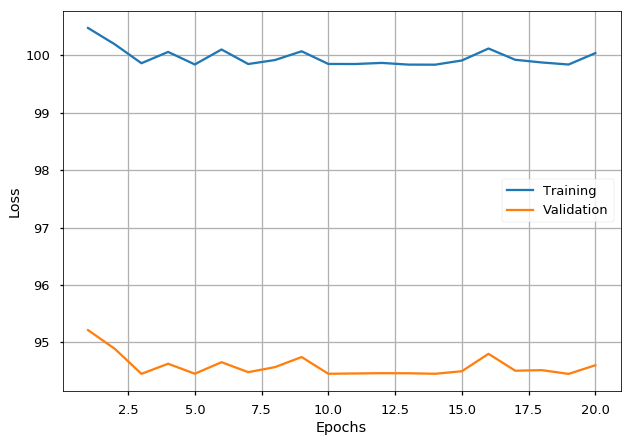

In [39]:
# Plot the results
epochs = np.arange(1,21)
train_loss = []
valid_loss = []
for e in epochs:
    print("Training with %d epochs..." % e)
    t, v = train_for_epochs(e)
    train_loss.append(t)
    valid_loss.append(v)
    
plt.figure(figsize=(10,7))
plt.plot(epochs, train_loss, label='Training')
plt.plot(epochs, valid_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

So the model does not look exceptionally good. This is normal, we have just tried a linear model without any kind of feature engineering or transformation; we don't know for instance if the relationship between *fare_amount* and the rest of features is linear or not.

Let's try another simple model using TF, but this one will be more complex

## A more complex model

We are going to reuse a lot of code from the previous model, we will just change the kind of estimator we are using.

Let's repeat the same estimator again, and we will run it for 20 epochs this time. Then we will compare it with the new one:

In [43]:
tf.logging.set_verbosity(tf.logging.ERROR)
OUTDIR = 'taxi_trained'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

def train_for_epochs_dl(nepochs):
    tf_train = pandas2tf(df_train, nepochs)
    tf_valid = pandas2tf(df_valid, nepochs)
    model = tf.estimator.DNNRegressor(hidden_units=[32, 8, 2], feature_columns=feature_cols,
                                         model_dir=OUTDIR)
    model.train(tf_train)
    train_loss = model.evaluate(tf_train)['average_loss']
    valid_loss = model.evaluate(tf_valid)['average_loss']
    return train_loss, valid_loss

Training with 1 epochs...
Training with 2 epochs...
Training with 3 epochs...
Training with 4 epochs...
Training with 5 epochs...
Training with 6 epochs...
Training with 7 epochs...
Training with 8 epochs...
Training with 9 epochs...
Training with 10 epochs...
Training with 11 epochs...
Training with 12 epochs...
Training with 13 epochs...
Training with 14 epochs...
Training with 15 epochs...
Training with 16 epochs...
Training with 17 epochs...
Training with 18 epochs...
Training with 19 epochs...
Training with 20 epochs...


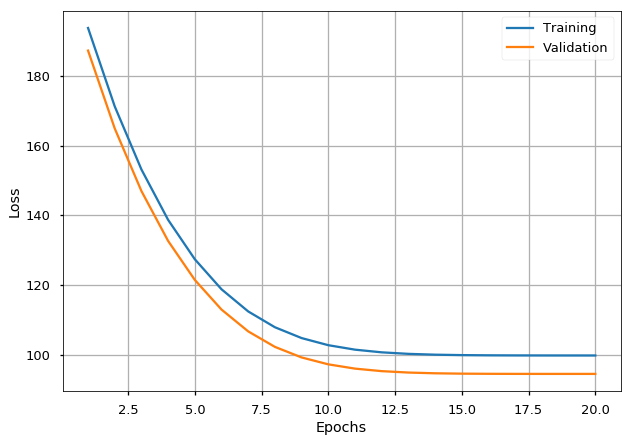

In [44]:
shutil.rmtree(OUTDIR, ignore_errors = True)

# Plot the results
epochs = np.arange(1,21)
train_dl_loss = []
valid_dl_loss = []
for e in epochs:
    print("Training with %d epochs..." % e)
    t, v = train_for_epochs_dl(e)
    train_dl_loss.append(t)
    valid_dl_loss.append(v)

plt.figure(figsize=(10,7))
plt.plot(epochs, train_dl_loss, label='Training')
plt.plot(epochs, valid_dl_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

Is this new model better? Why does not the linear model change with the number of epochs?

What would you do next to improve the Deep Learning model?
* Possible answers: increase the number of epochs, maybe try a more complex model. Any other hyperparam?

Let's try with 150 epochs, and see if we can beat the training and validation loss

In [45]:
tf_train = pandas2tf(df_train, 150)
tf_valid = pandas2tf(df_valid, 150)
tf_test = pandas2tf(df_test, 150)

shutil.rmtree(OUTDIR, ignore_errors = True)
dl_model = tf.estimator.DNNRegressor(hidden_units=[32, 8, 2],
                                    feature_columns=feature_cols)
dl_model.evaluate(tf_test)

{'average_loss': 213.31386,
 'label/mean': 11.104369,
 'loss': 27302.012,
 'prediction/mean': 0.0,
 'global_step': 0}

## Final decision about the models

So far, we have been ignoring the test set. We have used the validation dataset to change the hyperparameters of the model. It is now the turn to use the test set to finally decide which model is better: the linear regressor or the neural network.

For this, we can retrain the models using both the train and validation sets, with the hyperparameters that we have already decided. Then we will evaluate both models using only the test set, and we will find out which one is better predicting the test set, that is, a set of data that has not been used in any way to tune the model (the validation set has been used to tune the hyperparams, so somehow the validation set info is already included in the model).

In [ ]:
# Evaluate the LinearRegressor model

In [ ]:
# Evaluate tf.estimator.DNNRegressor model